## Make maps of the cluster computations

In [1]:
%matplotlib inline

In [2]:
import warnings

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

import gsw
import cmocean.cm as cm

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

warnings.simplefilter('ignore')

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


#### Functions

In [3]:
def non_nan(array):
    lon = datm.lon.values.flatten()
    lat = datm.lat.values.flatten()
    ar = datm[array].values.flatten()

    mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(ar)
    lon = lon[mask]
    lat = lat[mask]
    ar = ar[mask]
    return lon,lat,ar

def grid_da(xi,yi,array,method='linear'):
    ''' Grid cluster data onto regular grid
    '''
    from scipy.interpolate import griddata

    lon = datm.lon.values.flatten()
    lat = datm.lat.values.flatten()
    ar = datm[array].values.flatten()

    mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(ar)
    lon = lon[mask]
    lat = lat[mask]
    ar = ar[mask]
    
    zi = griddata((lon, lat), ar, (xi[None,:], yi[:,None]), method=method )
    return zi

def alphabet(ax):
    for j, axx in enumerate(ax):
        axx.annotate(chr(j+65), (0, 1.02),
                     xycoords='axes fraction',
                     weight='bold')

#### Main program

In [10]:
dat = xr.open_mfdataset('../data/clusters/combinations_lt_10_*.nc',concat_dim='clusters',)

In [11]:
datm = dat.mean(dim='id')
datm = datm.sel(time=slice('2015-09-02','2015-09-14'))
datm['sigma'] =  (('clusters','time'),gsw.density.rho(datm.sal,datm.sst,0)-1000)

In [12]:
xi = np.linspace(87.75,89.5, 50)
yi = np.linspace(15.75,17.5, 50)
zsigma = grid_da(xi,yi,'sigma')

In [13]:
fullpage = tuple( np.array([19.0,23.0])/2.54 )
quarterpage = tuple( np.array([9.5,11.5])/2.54 )
halfpage_hor = tuple( np.array([19.0,11.5])/2.54 )
halfpage_ver = tuple( np.array([9.5,23.0])/2.54 )

In [14]:
def annotate_stats(array,ax):
    from scipy.stats import skew
    
    test = datm[array].values.flatten()
    sk,mean= skew(test[np.isfinite(test)]),np.nanmean(test)
    return ax.annotate(rf'sk: {sk:2.2f}'+'\n'+rf'm: {mean:2.2f}',(0.58,0.78), xycoords='axes fraction', fontsize=15)

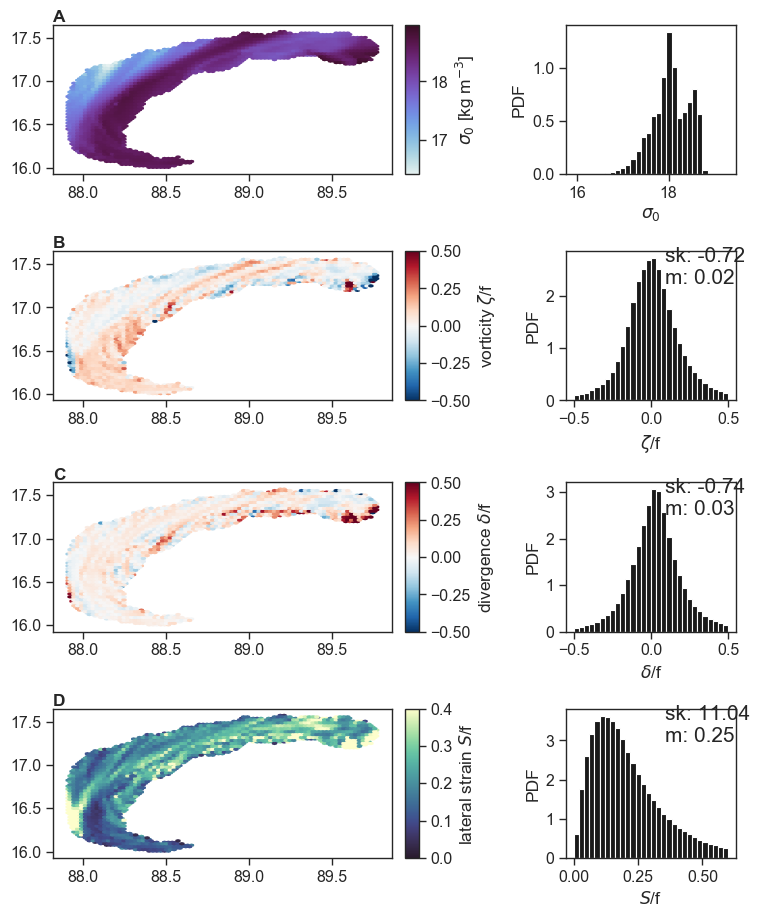

In [15]:
f = plt.figure(constrained_layout=True,figsize=fullpage)
widths = [2 ,0.08, 1]
heights = [1, 1, 1, 1]
spec = f.add_gridspec(ncols=3,
                      nrows=4,
                      width_ratios=widths,
                      height_ratios=heights,)

ax0 = f.add_subplot(spec[0, 0])
lon,lat,ar = non_nan('sigma')
h = ax0.hexbin(lon,lat,ar, cmap=cm.dense, gridsize=80)
ax0c = f.add_subplot(spec[0, 1])
plt.colorbar(h, cax=ax0c, label=r'$\sigma_0$ [kg m$^{-3}$]')#, pad=0.01)

ax0h = f.add_subplot(spec[0, 2])
datm.sigma.plot.hist(ax=ax0h, density=True, bins=30, color='k')
ax0h.set_xlabel(r'$\sigma_0$')
ax0h.set_ylabel('PDF')
ax0h.set_title(None)

ax1 = f.add_subplot(spec[1, 0])
lon,lat,ar = non_nan('vort')
h = ax1.hexbin(lon,lat,ar,vmin=-0.5,vmax=0.5, cmap='RdBu_r', gridsize=80)
ax1c = f.add_subplot(spec[1, 1])
plt.colorbar(h,cax=ax1c, label=r'vorticity $\zeta$/f')#, pad=0.01)

ax1h = f.add_subplot(spec[1, 2])
datm.vort.plot.hist(ax=ax1h, range=(-0.5,0.5), density=True, bins=30, color='k')
ax1h.set_xlabel(r'$\zeta$/f')
ax1h.set_ylabel('PDF')
ax1h.set_title(None)
annotate_stats('vort',ax1h)

ax2 = f.add_subplot(spec[2, 0])
lon,lat,ar = non_nan('div')
h = ax2.hexbin(lon,lat,ar,vmin=-0.5,vmax=0.5, cmap='RdBu_r', gridsize=80)
ax2c = f.add_subplot(spec[2, 1])
plt.colorbar(h,cax=ax2c, label=r'divergence $\delta$/f')#, pad=0.01)

ax2h = f.add_subplot(spec[2, 2])
datm.div.plot.hist(ax=ax2h, range=(-0.5,0.5), density=True, bins=30, color='k')
ax2h.set_xlabel(r'$\delta$/f')
ax2h.set_ylabel('PDF')
ax2h.set_title(None)
annotate_stats('div',ax2h)

ax3 = f.add_subplot(spec[3, 0])
lon,lat,ar = non_nan('strain')
h = ax3.hexbin(lon,lat,ar,vmin=0,vmax=0.4, cmap=cm.deep_r, gridsize=80)
ax3c = f.add_subplot(spec[3, 1])
plt.colorbar(h,cax=ax3c, label=r'lateral strain $S$/f')#, pad=0.01)

ax3h = f.add_subplot(spec[3, 2])
datm.strain.plot.hist(ax=ax3h, range=(0,0.6), density=True, bins=30, color='k')
ax3h.set_xlabel(r'$S$/f')
ax3h.set_ylabel('PDF')
ax3h.set_title(None)
annotate_stats('strain',ax3h)

alphabet( [ax0,ax1,ax2,ax3])

# plt.subplots_adjust(hspace=0.1,wspace=0.25)
plt.savefig('maps_hist.pdf')